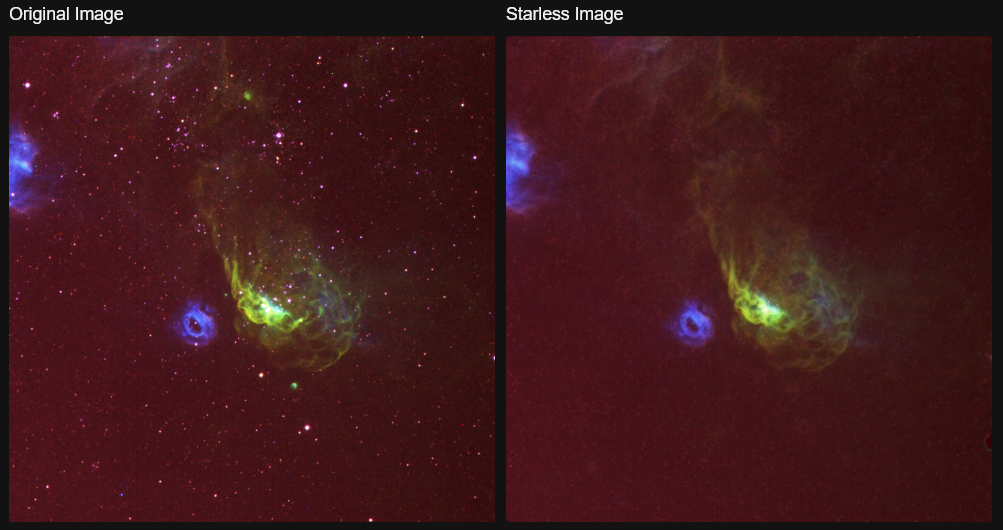

#### 💡Try this model in your browser now : https://ashishware.com/static/star_removal/index.html
#### 📥 Download and install star removal tool for working with large images: https://github.com/code2k13/starreduction

## What does this notebook do ?
It is a well known fact that the universe is full of stars. However, there are not as many stars as there should be in images of astronomical objects we see in books, websites and on TV are 'heavily'. The reason, being these images are digitially processed and enhanced. Special techniques and software are used to remove starts from these images. This notebook trains a GAN (a type of neural network) to remove stars from deep sky images. The code is inspired by [sample from tensorflow's website](https://www.tensorflow.org/tutorials/generative/pix2pix). 

## Where did I get my training data ?
The training is randomly created by augumenting one of the below images:
- Image of Helix nebula
- A 'turbulence' image created artificially using GIMP, that mimics nebulosity

with a star map with transparent background created out of image of NGC 3572 Star Cluster. Essentially the training dataset is created out of just three images.
  
## How is training data generated ?
![Generation of training data](https://github.com/code2k13/starreduction/raw/main/images/creating_training_images.jpg)

The training data is generated on the fly, using *get_dataset_batch* method. Basically, I use only three images to create the training data. Background is either an image of Helix nebula or 'turbulence', the foreground layer is the star map. Each layer is obtained by croping the base image, then scaling , followed by augmentation. This results in unlimited number of images with different star sizes and object sizes. 

## How to work with large images ?
You can use this trained model with tiles based approach to divide a large image in smaller portions and perform star removal. I have written a open source tool that just does that 😎https://github.com/code2k13/starreduction. You can run it using python or docker. Should work with all operating systems.

In [ ]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image, ImageFilter,ImageEnhance
import cv2
import random
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
IMG_SIZE = 512
OUTPUT_CHANNELS = 1
LAMBDA = 10 

In [ ]:
def downsample(filters, size, apply_batchnorm=True,strides = 2,name=''):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential(name=name)
  result.add(tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
def upsample(filters, size, apply_dropout=False,strides = 2,name=''):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential(name=name)
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,padding='same',
                                    kernel_initializer=initializer,use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))        
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS])

  down_stack = [
    downsample(16, 5, apply_batchnorm=False,strides = 1, name='gd_1'),  # (batch_size, 128, 128, 64)
    downsample(32, 5,name='gd_2'),  # (batch_size, 64, 64, 128)
    downsample(64, 5,name='gd_3'),  # (batch_size, 32, 32, 256)
    downsample(128, 5,name='gd_4'),  # (batch_size, 16, 16, 512)
    downsample(256, 5,name='gd_5'),  # (batch_size, 8, 8, 512)
    downsample(256, 5,name='gd_6'),  # (batch_size, 4, 4, 512)
    downsample(512, 5,name='gd_7'),  # (batch_size, 2, 2, 512)
    downsample(512, 5,name='gd_8'),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 5, apply_dropout=True,name='gu_1'),  # (batch_size, 2, 2, 1024)
    upsample(256, 5, apply_dropout=True,name='gu_2'),  # (batch_size, 4, 4, 1024)
    upsample(256, 5, apply_dropout=True,name='gu_3'),  # (batch_size, 8, 8, 1024)      
    upsample(128, 5,name='gu_4'),  # (batch_size, 16, 16, 1024)
    upsample(64, 5,name='gu_5'),  # (batch_size, 32, 32, 512)
    upsample(32, 5,name='gu_6'),  # (batch_size, 64, 64, 256)
    upsample(16, 5,name='gu_7'),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=1,padding='same',
                                         kernel_initializer=initializer,activation='relu')  # (batch_size, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target,disc_target_int_op,disc_gen_int_op):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))  
  gd1_loss = tf.reduce_mean(tf.abs(disc_target_int_op[0] - disc_gen_int_op[0]))
  gd2_loss = tf.reduce_mean(tf.abs(disc_target_int_op[1] - disc_gen_int_op[1]))
  gd3_loss = tf.reduce_mean(tf.abs(disc_target_int_op[2] - disc_gen_int_op[2]))
  gd4_loss = tf.reduce_mean(tf.abs(disc_target_int_op[3] - disc_gen_int_op[3]))
    

  total_gen_loss = gan_loss + (LAMBDA * l1_loss) + gd1_loss + gd2_loss + gd3_loss + gd4_loss
  return total_gen_loss, gan_loss, l1_loss

In [ ]:

def Discriminator(): 
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name='target_image')
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
  down0 = downsample(16, 4, False,name='dd_1')(x) 
  down1 = downsample(32, 4,name='dd_2')(down0)  # (batch_size, 128, 128, 64)
  down2 = downsample(64, 4,name='dd_3')(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(128, 4,name='dd_4')(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=[last,down0,down1,down2,down3])

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output,a,b,c,d = discriminator([input_image, target], training=True)
        dr1 = [a,b,c,d]
        
        disc_generated_output,e,f,g,h = discriminator([input_image, gen_output], training=True)
        dr2 = [e,f,g,h]
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target,
                                                                  dr1,dr2)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
import albumentations as A
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.02),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.5625, scale_limit=0.8, rotate_limit=145, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3)
    ])

 

We are generating images on the fly. 

In [ ]:
!wget https://raw.githubusercontent.com/code2k13/starreduction/main/images/helix_bw_base.jpg
!wget https://github.com/code2k13/starreduction/raw/main/training_data/star_map_base.png
!wget https://github.com/code2k13/starreduction/raw/main/training_data/turbulence.jpg

In [ ]:
flip = False

In [ ]:
from PIL import Image, ImageFilter
def get_dataset_batch(batch_size = 2):
    flip = False    
    im2 = Image.open("star_map_base.png")
    trainA = []
    trainB = []
    for i in range(0,batch_size):
        if flip == True:
            turbulence_size = random.choice([1,2,3,4])
            im = Image.open("turbulence.jpg")
            x = random.randint(0,4096-IMG_SIZE*turbulence_size)
            y =  random.randint(0,2136-IMG_SIZE*turbulence_size)
            corp_actual_rect = (x, y, x+IMG_SIZE*turbulence_size, y+IMG_SIZE*turbulence_size)    
            corped_actual = im.crop(corp_actual_rect)
            corped_actual = corped_actual.resize((IMG_SIZE,IMG_SIZE))      
        else:
            helix_size = random.choice([1,2,3,4,5,6,7])
            im = Image.open("helix_bw_base.jpg")
            x = random.randint(0,4096-IMG_SIZE*helix_size)
            y = random.randint(0,4096-IMG_SIZE*helix_size)
            corp_actual_rect = (x, y, x+IMG_SIZE*helix_size, y+IMG_SIZE*helix_size)
            corped_actual = im.crop(corp_actual_rect)
            corped_actual = corped_actual.resize((IMG_SIZE,IMG_SIZE))
        flip = not flip
        corped_actual = corped_actual.convert('LA')
        #enhancer1 = ImageEnhance.Brightness(corped_actual)
        #factor =   0.15 + random.random()*1
        star_overlayed = corped_actual #enhancer1.enhance(factor)  
        star_overlayed = star_overlayed.rotate(random.randint(1,360), expand=False) 
        star_overlayed = star_overlayed.convert('L')
        star_overlayed = Image.fromarray(transform(image = np.asarray(star_overlayed))["image"]/1)
        star_overlayed = star_overlayed.convert('LA')
        ca  = star_overlayed.copy()          
        ca = ca.convert('L') 

        im2 = im2.convert('RGBA')
        star_overlayed = star_overlayed.convert('RGBA')  
        op = overlay_images(star_overlayed,im2)
        op = Image.fromarray(op)
         
        star_overlayed = op.convert('L')
        a = np.asarray(ca,dtype="float32").reshape(1,IMG_SIZE,IMG_SIZE,1)/512          
        b = np.asarray(star_overlayed,dtype="float32").reshape(1,IMG_SIZE,IMG_SIZE,1)/512               
        trainA.append(a)
        trainB.append(b)    
    return trainA,trainB

In [ ]:


def overlay_images(background, star_mask):
    
    x = random.randint(0,1024-IMG_SIZE)
    y =  random.randint(0,1024-IMG_SIZE)
    crop_rectangle = (x, y, x+IMG_SIZE, y+IMG_SIZE)   
    scale_factor = random.choice([0.25,0.5,0.75,1,2,4,8])
    foreground = star_mask.resize((int(IMG_SIZE*scale_factor),int(IMG_SIZE*scale_factor)))
    if foreground.size[0] > background.size[0]:
        foreground = foreground.filter(ImageFilter.GaussianBlur(2))
        foreground = foreground.crop(crop_rectangle) 
    b_img = np.array(background) 
    f_img = np.array(foreground) 
    y1, y2 = 0,b_img.shape[0]
    x1, x2 = 0,b_img.shape[1]    
    fx,fy = f_img.shape[0],f_img.shape[1]
    for c in range(0, 3):
        for x in range(0,int(x2/fx)):
            for y in range(0,int(y2/fy)):
                temp = foreground.rotate(random.choice([0,90,180,270,360]), expand=False)  
                temp = np.array(temp)   
                f_alpha = temp[:, :, 3] / 256.0
                b_alpha = 1.0 - f_alpha
                b_img[y*fy:y*fy+fy ,x*fx:x*fx+fx, c] = (f_alpha * temp[:, :, c] +
                                          b_alpha *  b_img[y*fy:y*fy+fy ,x*fx:x*fx+fx, c] *1) 

    return b_img.astype('uint8')

In [ ]:
plt.rcParams['figure.figsize'] = (30, 10)
random.seed(10)
test_starless, test_stars = get_dataset_batch(20)

In [ ]:
idx = 16
plt.imshow(test_stars[idx].reshape((IMG_SIZE,IMG_SIZE,1)),cmap='gray')
plt.show()
plt.imshow(test_starless[idx].reshape((IMG_SIZE,IMG_SIZE,1)),cmap='gray')
plt.show()

In [ ]:
import datetime
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

There is no real notion of 'epochs' here. Everytime random image is being created for training. We have some control over repetability using the 'n' variable which is reset to 'total_samples' everytime it exceeds 'total_samples'. This 'n' variable is used as random seed before creation of images.

In [ ]:
from matplotlib.pyplot import figure
EPOCHS = 16000
SAVE_MODEL_AFTER = 800
n = 0
total_samples = 500
BATCH_SIZE = 2
plt.rcParams['figure.figsize'] = (15, 5)

for epoch in range(EPOCHS):
    #random.seed(n)
    #print(epoch)
    train_starless, train_stars = get_dataset_batch(BATCH_SIZE)
    start = time.time()
    train_step(np.asarray(train_stars).reshape((-1,IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),
               np.asarray(train_starless).reshape((-1,IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),n)
    
    if (epoch + 1) % SAVE_MODEL_AFTER == 0:
        generator.save_weights("generator" + str(epoch))
        #ckpt_save_path = checkpoint.save('test_')
        print ('Saving checkpoint for epoch {} '.format(epoch+1))
        sample_prediction = generator(test_stars[8], training=False)
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(test_starless[8].reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        axarr[1].imshow(test_stars[8].reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        axarr[2].imshow(sample_prediction.numpy().reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        #axarr.imshow()
        plt.show()
        sample_prediction = generator(test_stars[5], training=False)
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(test_starless[5].reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        axarr[1].imshow(test_stars[5].reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        axarr[2].imshow(sample_prediction.numpy().reshape((IMG_SIZE,IMG_SIZE,OUTPUT_CHANNELS)),cmap="gray")
        #axarr.imshow()
        plt.show()
    n = n + BATCH_SIZE
    if n > total_samples:
        n = 0

In [ ]:
!rm test*

## Attributions
### Star cluster NGC 3572 and its surroundings
This image was downloaded from Wikimedia Commons and star mask was created by me using GIMP

Link to the processed image: [https://github.com/code2k13/starreduction/blob/main/training_data/star_map_base.png?raw=true](star_map_base.png)

> [ESO/G. Beccari, CC BY 4.0](https://creativecommons.org/licenses/by/4.0), via Wikimedia Commons

Url: [https://commons.wikimedia.org/wiki/File:The_star_cluster_NGC_3572_and_its_dramatic_surroundings.jpg](https://commons.wikimedia.org/wiki/File:The_star_cluster_NGC_3572_and_its_dramatic_surroundings.jpg) 

Direct Link: [https://upload.wikimedia.org/wikipedia/commons/9/95/The_star_cluster_NGC_3572_and_its_dramatic_surroundings.jpg](https://upload.wikimedia.org/wikipedia/commons/9/95/The_star_cluster_NGC_3572_and_its_dramatic_surroundings.jpg)